In [ ]:
!pip install matrix-completion -q

In [ ]:
import numpy as np 
import pandas as pd
from matrix_completion import pmf_solve, svt_solve
from scipy.stats import pearsonr, kendalltau
from sklearn.isotonic import IsotonicRegression
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_excel('/content/data.xlsx')

In [ ]:
experts = df.columns[6:]

In [ ]:
expert_estimates = df[experts].fillna(0).values
mask = expert_estimates != 0

In [ ]:
R_hat = svt_solve(expert_estimates, mask, epsilon=0.07)

In [ ]:
M = np.zeros((len(R_hat), len(R_hat)))
for i in range(len(R_hat)):
    for j in range(i, len(R_hat)):
        M[i, j] = kendalltau(R_hat[i], R_hat[j])[0]
        M[j, i] = M[i, j]

In [ ]:
np.median(M, axis=1)

array([ 0.        ,  0.03030303,  0.03030303, -0.06060606,  0.03030303,
       -0.06060606,  0.12121212, -0.03030303,  0.03030303])

In [ ]:
expert_score = np.corrcoef(R_hat.T).mean(0)
expert_rank = np.argsort(expert_score)

In [ ]:
expert_score

array([ 0.06903422,  0.05340581,  0.21500023,  0.0060369 ,  0.16932247,
        0.09156626,  0.04222482,  0.20818006,  0.20244757,  0.13134664,
        0.1670649 , -0.07747331])

In [ ]:
map_col2name = {i:df.columns[6+i] for i in range(len(df.columns[6:]))}

In [ ]:
[map_col2name[expert] for expert in expert_rank]

['Алсаханова',
 'Тихонов',
 'Харь',
 'Гребенькова',
 'Стрижов',
 'Панкратов',
 'Волынцев',
 'Христолюбов',
 'Панченко',
 'Исламов',
 'Савельев',
 'Михеев']

In [ ]:
df['Ценность'] = df['Калорийность, кКал'] / df['Цена 100г, руб.']

In [ ]:
weights = np.argsort(np.argsort(np.corrcoef(R_hat.T).mean(0))) + 1

In [ ]:
expert_outputs = []
for _, elem in df.iterrows():
    mask = ~elem[6:-1].isna() 
    expert_outputs.append(np.nansum(weights * elem[6:-1]) / (weights * mask).sum())

In [ ]:
df[df.columns[0]]

0                                              Устрицы
1                                       Арахиc соленый
2                                          Молоко 2,5%
3                                             Макароны
4                                  Овсяное молоко 3.2%
5                                              Шоколад
6    Сырок "РОСТАГРОЭКСПОРТ" творожный глазированны...
7                                           Кефир 3.2%
8                                      Гречневая крупа
Name: Объект, dtype: object

In [ ]:
match = list(zip(expert_outputs, df[df.columns[0]]))

In [ ]:
pred = sorted(match, key=lambda x: x[0])

In [ ]:
pred

[(2.112676056338028,
  'Сырок "РОСТАГРОЭКСПОРТ" творожный глазированный с "Варенкой"'),
 (3.2222222222222223, 'Шоколад'),
 (3.9358974358974357, 'Молоко 2,5%'),
 (4.4, 'Макароны'),
 (4.5, 'Арахиc соленый'),
 (4.717948717948718, 'Гречневая крупа'),
 (5.655172413793103, 'Устрицы'),
 (5.984848484848484, 'Овсяное молоко 3.2%'),
 (6.0, 'Кефир 3.2%')]

In [ ]:
pred_name = [elem[1] for elem in pred]

In [ ]:
pred_name

['Сырок "РОСТАГРОЭКСПОРТ" творожный глазированный с "Варенкой"',
 'Шоколад',
 'Молоко 2,5%',
 'Макароны',
 'Арахиc соленый',
 'Гречневая крупа',
 'Устрицы',
 'Овсяное молоко 3.2%',
 'Кефир 3.2%']

In [ ]:
my_rating = {elem: i for i, elem in enumerate(pred_name)}
first_rating = {"Устрицы": 9, "Арахиc соленый" : 4,
"Молоко 2,5%": 5,	"Макароны": 6, "Овсяное молоко 3.2%":8, "Шоколад":2, 
'Сырок "РОСТАГРОЭКСПОРТ" творожный глазированный с "Варенкой"':1, 	"Кефир 3.2%":7,	
"Гречневая крупа": 3}
rus_rating = dict(zip(list(first_rating.keys()), (9,3,8,4,5,1,6,7,2)))

In [ ]:
def plot_rating(my_rating, other_rating):
    out = []
    for elem in my_rating:
        out.append(other_rating[elem])

    plt.scatter(range(1,10), out, label=list())
    for i, label in enumerate(my_rating.keys()):
        plt.annotate(label, (i+1, other_rating[label]))
    plt.plot(range(1, 10), range(1, 10))
    plt.grid()
    plt.xlabel("Мой")
    plt.ylabel("Аноним")
    plt.savefig("2.png")
    plt.show()

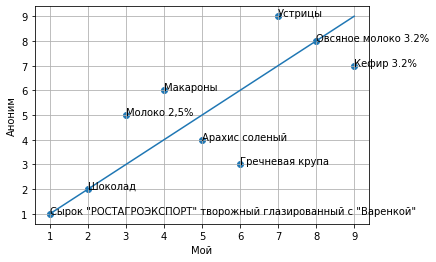

In [ ]:
plot_rating(my_rating, first_rating)

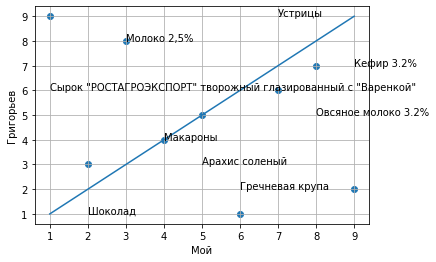

In [ ]:
plt.scatter(range(1,10), rus_rating.values(), label=list())
for i, label in enumerate(my_rating.keys()):
    plt.annotate(label, (i+1, rus_rating[label]))
plt.plot(range(1, 10), range(1, 10))
plt.grid()
plt.xlabel("Мой")
plt.ylabel("Григорьев")
plt.show()

### Рейтинг реитингов

In [ ]:
def levenshtein(x, y):
    """ Levenshtein distance
          using Dynamic-Programming strategy
    Parameters
    ----------
    x, y : np.array of string
    Returns
    -------
    int : distance
    np.array : distance matrix
    """
    # Initiallize DP-matrix
    D = np.zeros((len(x) + 1, len(y) + 1), dtype=int)
    D[0, 1:] = range(1, len(y) + 1)
    D[1:, 0] = range(1, len(x) + 1)

    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            delta = 2 if x[i - 1] != y[j - 1] else 0
            D[i, j] = min(D[i - 1, j - 1] + delta, D[i - 1, j] + 1, D[i, j - 1] + 1)
    return D[-1, -1], D

In [ ]:
ratings = pd.read_excel('rating.xlsx')

In [ ]:
experts_rates = ratings.columns[1:]
experts_names = ratings[ratings.columns[0]]

In [ ]:
X = ratings[experts_rates].values

In [ ]:
dist = np.argsort(np.argsort(X.mean(0))) + 1

In [ ]:
levenshtein_dists = []
for i in range(len(X)):
    levenshtein_dists.append(levenshtein(dist, X[i])[0])

In [ ]:
dist_score = np.argsort(levenshtein_dists) + 1

In [ ]:
corr_score = np.corrcoef(X).mean(0)
expert_score = np.argsort(-corr_score) + 1

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

In [ ]:
pca_score = np.argsort(-X @ pca.components_[-1].T) + 1

In [ ]:
pca_score

array([ 7,  3, 10,  6, 14, 15, 13,  5,  1,  8,  2, 12, 11,  4,  9])

In [ ]:
final_score = pca_score + expert_score + 0.1 * dist_score + work_score

In [ ]:
match_ratings = list(zip(experts_names, final_score))

In [ ]:
np.argsort(np.argsort(final_score)) + 1

array([ 3,  2,  5, 12,  9, 15,  8,  6,  7, 11,  1, 14, 10,  4, 13])

In [ ]:
sorted(match_ratings, key=lambda x: x[1])

[('Панченко Святослав', 7.5),
 ('Григорьев Алексей', 8.0),
 ('Вареник Наталия', 8.1),
 ('Северилов', 11.3),
 ('Алсаханова', 12.4),
 ('Бишук Антон', 12.7),
 ('Гребенькова Ольга', 13.2),
 ('Филатов Андрей', 16.3),
 ('Савельев Николай', 17.1),
 ('Харь Александра', 20.9),
 ('Вайсер Кирилл', 21.5),
 ('Мокров Петр', 21.8),
 ('Гунаев', 24.4),
 ('Панкратов Виктор', 25.6),
 ('Исламов Рустем', 26.2)]